In [1]:
from sentence_transformers import SentenceTransformer, LoggingHandler, InputExample
from sentence_transformers import models, util, datasets, evaluation, losses
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelWithLMHead, AutoModelForMaskedLM, AutoConfig, BertConfig, AutoModelForCausalLM, BertGenerationDecoder
import pandas as pd
import json
import umap
from custom_TSDAE import *
import os
import umap
import matplotlib.pyplot as plt


# Load data

In [2]:
finetune_data = pd.read_csv("processed_data/clinvar_processed_snvs.csv")
finetune_data

,ReferenceSequence,MutatedSequence,ClinicalSignificance,OriginSimple,GeneSymbol,HGNC_ID,PhenotypeList,RS# (dbSNP)
0,CACCTGCGGGTGAGT,CACCTGCAGGTGAGT,Uncertain significance,germline,ZNF592,HGNC:28986,Galloway-Mowat syndrome 1,150829393
1,AAAGGTCCAGTCCTT,AAAGGTCTAGTCCTT,Pathogenic,germline,FOXRED1,HGNC:26927,"Mitochondrial complex 1 deficiency, nuclear ty...",267606829
2,GTTGTCAACATGTAC,GTTGTCAGCATGTAC,Pathogenic,germline,FOXRED1,HGNC:26927,"Mitochondrial complex 1 deficiency, nuclear ty...",267606830
3,GTCCCGAGGACTTCC,GTCCCGAAGACTTCC,Uncertain significance,germline,NUBPL,HGNC:20278,not provided|Inborn genetic diseases|Mitochond...,200401432
4,TATACGTGCCAGGTG,TATACGTACCAGGTG,Conflicting interpretations of pathogenicity; ...,germline,HFE,HGNC:4886,Hemochromatosis type 1|Porphyria cutanea tarda...,1800562
...,...,...,...,...,...,...,...,...
2507792,GAACCGGGACCTTGC,GAACCGGCACCTTGC,Likely pathogenic,germline,GAA,HGNC:4065,"Glycogen storage disease, type II",-1
2507793,CAGCAAGAGATGAGC,CAGCAAGTGATGAGC,Uncertain significance,germline,DHTKD1,HGNC:23537,Charcot-Marie-Tooth disease axonal type 2Q,778723208
2507794,GATGGGCCCAACGCC,GATGGGCTCAACGCC,Likely pathogenic,germline,COL2A1,HGNC:2200,Spondyloepiphyseal dysplasia congenita,-1
2507795,CTATGCCAACAAGCA,CTATGCCGACAAGCA,Likely pathogenic,germline,NAGLU,HGNC:7632,"Mucopolysaccharidosis, MPS-III-B",-1


In [3]:
test_data = pd.read_csv("processed_data/cogvig_data.csv")
test_data

,ReferenceSequence,MutatedSequence,type,Molecular_Consequence,Gene,disease,dbSNP
0,ACTATTCGGTGCGTT,ACTATTCTGTGCGTT,nonsynonymous SNV,SO:0001583|missense_variant\nSO:0001627|intron...,CDKN2A,Hereditary_cancer-predisposing_syndrome\nHered...,rs373407950(chr9-21974705-GtoT)
1,TTCCAAAATCCGTTT,TTCCAAAGTCCGTTT,nonsynonymous SNV,'-,TSC1,.,rs1374339026(chr9-135772897-AtoG)
2,CTTCGTTGCTTGCTG,CTTCGTTCCTTGCTG,nonsynonymous SNV,'-,RASA1,.,rs779313090(chr5-86564637-GtoC)
3,CTGCCACCCATCAGG,CTGCCACACATCAGG,nonsynonymous SNV,'-,CSF1R,.,rs753500118(chr5-149459663-CtoA)
4,TTAAATCTGGGAGGC,TTAAATCCGGGAGGC,nonsynonymous SNV,'-,RHOA,.,rs1310116062(chr3-49398430-TtoC)
...,...,...,...,...,...,...,...
418,CAAAACTGATAATCA,CAAAACTAATAATCA,stopgain,SO:0001587|nonsense,FANCC,"Fanconi_anemia\nFanconi_anemia,_complementatio...",rs121917784(chr9-98011537-GtoA)
419,ACCTGATCCATGTAA,ACCTGATTCATGTAA,nonsynonymous SNV,'-,PTCH1,.,rs780378700(chr9-98244421-CtoT)
420,AGTTCCATGGCCCTC,AGTTCCACGGCCCTC,nonsynonymous SNV,'-,PTCH1,.,rs755103500(chr9-98279102-TtoC)
421,GGATGAGAGTTACCT,GGATGAGCGTTACCT,nonsynonymous SNV,SO:0001583|missense_variant,DKC1,Dyskeratosis_congenita\nDyskeratosis_congenita...,rs146700772(chrX-153997508-AtoC)


# Instantiate model and dataloaders

In [4]:
model_name = 'zhihan1996/DNA_bert_3'
#model_name = "Peltarion/dnabert-minilm-mini"
tokenizer = AutoTokenizer.from_pretrained(model_name)

embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(768, 'cls')
model = SentenceTransformer(modules=[embedding_model, pooling_model])
model.tokenizer = tokenizer

decoder_config = BertConfig.from_json_file("decoder_config.json")

Some weights of the model checkpoint at zhihan1996/DNA_bert_3 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
train_dataset = CustomTSDAE_Dataset(finetune_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=64, collate_fn=lambda x: x, shuffle=True)

test_dataset = CustomTSDAE_Dataset(test_data, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=lambda x: x, shuffle=False)

Preprocessing sequences
Preprocessing complete
Preprocessing sequences
Preprocessing complete


In [6]:
train_loss = CustomDenoisingAutoEncoderLoss(model, decoder_config, model_name)#, tie_encoder_decoder=True)

When tie_encoder_decoder=True, the decoder_name_or_path will be invalid.
Some weights of the model checkpoint at zhihan1996/DNA_bert_3 were not used when initializing BertLMHeadModel: ['bert.encoder.layer.5.attention.self.key.weight', 'bert.encoder.layer.8.attention.output.dense.weight', 'bert.encoder.layer.8.attention.self.key.weight', 'bert.encoder.layer.3.attention.output.dense.weight', 'bert.encoder.layer.6.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.dense.bias', 'bert.encoder.layer.3.output.dense.bias', 'bert.encoder.layer.10.attention.self.query.weight', 'bert.encoder.layer.2.attention.self.key.bias', 'bert.encoder.layer.6.intermediate.dense.bias', 'bert.encoder.layer.9.output.LayerNorm.weight', 'bert.encoder.layer.11.output.LayerNorm.bias', 'bert.encoder.layer.5.attention.self.query.weight', 'bert.encoder.layer.11.output.LayerNorm.weight', 'bert.encoder.layer.6.attention.output.dense.bias', 'bert.enco

In [7]:
dev_evaluator = LossEvaluator(test_dataloader, loss_model=train_loss, log_dir='logs/', name='dev')
best_loss = np.inf
if not os.path.exists("outputs"):
    os.mkdir("outputs")
    


def best_score_callback(score, epoch, steps):
    global best_loss
    
    if score<best_loss:
        print(f"New best model - Loss {score}")
        best_loss = score
        model.save('outputs/tsdae-model')
    return

In [8]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=20,
    steps_per_epoch=100,
    evaluator=dev_evaluator,
    weight_decay=1e-5,
    scheduler='constantlr',
    callback=best_score_callback,
    optimizer_params={'lr': 3e-6},
    show_progress_bar=True
)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 5.206889062557581


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 4.1091347055615115


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 3.55549275200322


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 3.103153849547764


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 2.662667359945909


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 2.2486347252467893


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.8859785187919185


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.6367970210201335


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.4855941624011633


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.3977635536553725


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.342017020819322


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.3036663442287806


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.2682253572176088


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.2422230333652136


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.216479404917303


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.195543849243308


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.179368698372031


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.1611525337651092


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.147315117548097


Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

New best model - Loss 1.1310338973999023


In [9]:
# Load model with best validation loss
best_model = SentenceTransformer('outputs/tsdae-model')

# Embed COGVIC germline variants

In [10]:
embedding_results = best_model(tokenizer(test_dataset.mutated_sequences, return_tensors="pt"))
variants_embeddings = embedding_results["sentence_embedding"].detach().numpy()
germline_embeddings = test_data[["dbSNP", "Gene", "disease"]].copy()
germline_embeddings.loc[:, [f"z{i}" for i in range(variants_embeddings.shape[-1])]] = variants_embeddings
germline_embeddings

,dbSNP,Gene,disease,z0,z1,z2,z3,z4,z5,z6,...,z758,z759,z760,z761,z762,z763,z764,z765,z766,z767
0,rs373407950(chr9-21974705-GtoT),CDKN2A,Hereditary_cancer-predisposing_syndrome\nHered...,0.137856,1.304762,-0.350797,-0.170449,-0.233094,-1.688197,0.402598,...,-1.116248,-3.047753,1.132886,-0.442223,0.166168,0.609442,-0.286504,-0.398218,1.008041,-0.240532
1,rs1374339026(chr9-135772897-AtoG),TSC1,.,0.178289,-0.620080,0.521250,-0.099729,0.234864,-2.155751,0.543393,...,-0.016643,-2.747691,0.350921,0.378368,0.336131,-0.736510,-0.642060,-0.070476,-1.340156,0.696337
2,rs779313090(chr5-86564637-GtoC),RASA1,.,-0.366823,1.352475,-0.312023,0.228880,0.929405,-1.038352,1.068501,...,-1.425530,-1.223110,0.813862,0.050696,0.290999,0.972817,-0.489651,0.254168,1.170988,-0.609160
3,rs753500118(chr5-149459663-CtoA),CSF1R,.,-0.947213,1.150305,0.414589,-0.601561,0.701059,-2.092129,-0.881780,...,-0.143314,-0.362253,0.416817,-1.600521,0.875007,0.831460,0.746343,-1.609833,-0.337709,-0.626772
4,rs1310116062(chr3-49398430-TtoC),RHOA,.,0.205896,-0.641042,1.614751,-0.100694,-0.709065,-2.573556,-0.851396,...,-0.375424,-1.795619,0.118982,-0.371557,0.621523,-0.252806,0.876569,-0.685753,-0.186040,-0.120817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,rs121917784(chr9-98011537-GtoA),FANCC,"Fanconi_anemia\nFanconi_anemia,_complementatio...",-0.038645,-0.061238,0.133292,-0.397203,-0.097362,-2.413872,0.204737,...,-0.550311,-2.999417,0.172530,-1.254124,0.542708,-0.141917,1.169940,-1.396796,1.762660,0.935347
419,rs780378700(chr9-98244421-CtoT),PTCH1,.,-0.084396,1.025185,-0.392708,-0.742551,-0.249570,-2.339588,0.310190,...,0.255359,-2.121872,0.211452,-0.689443,-0.473297,0.872161,0.697814,-1.072305,2.288765,-0.021590
420,rs755103500(chr9-98279102-TtoC),PTCH1,.,-0.663583,0.083364,0.249444,-0.407183,0.650535,-1.567198,-0.451419,...,-0.794830,-0.873582,0.991831,-0.876724,1.135393,-0.203184,0.415362,-0.134361,-0.400850,-0.914821
421,rs146700772(chrX-153997508-AtoC),DKC1,Dyskeratosis_congenita\nDyskeratosis_congenita...,-0.077061,0.619656,-0.365343,-0.254656,-0.202847,-2.275767,0.364359,...,0.049778,-2.032034,0.376245,-0.934358,0.209285,0.363973,0.661095,-1.590620,2.043539,0.007281


In [11]:
germline_embeddings.to_csv("COGVIC_germline_variants_embeddings.csv", index=False)

# Plot a representation of the cogvic embeddings

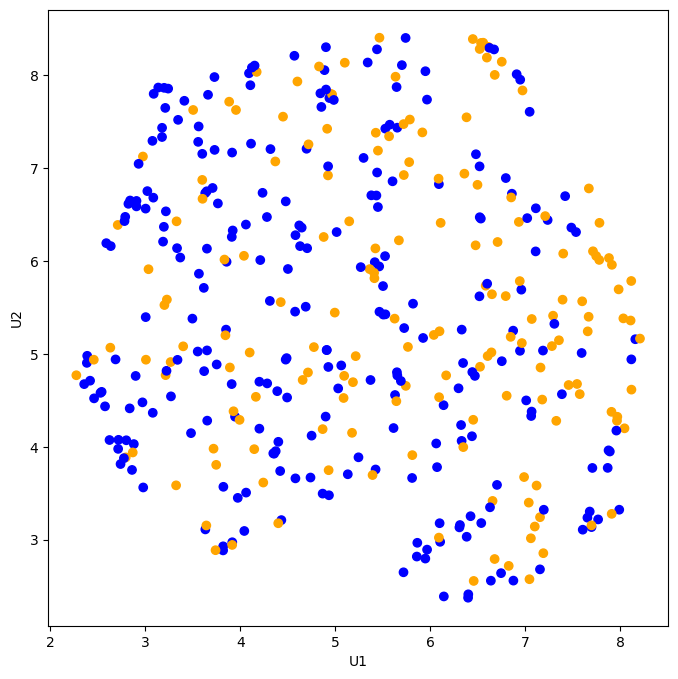

In [12]:
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(variants_embeddings)

fig, ax = plt.subplots(figsize=(8,8))

color = ["orange" if "Hereditary_cancer-predisposing_syndrome" in x else "blue" for x in germline_embeddings["disease"].values]
ax.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=color)
ax.set_xlabel("U1")
ax.set_ylabel("U2")

fig.savefig("images/COGVIC_UMAP_embeddings.png", facecolor="white")
plt.show()